# Matrix Factorization for Recommender Systems

In this project, I explore matrix factorization techniques for recommender systems. Here, matrix factorization is implemented with the help of scipy's svds() as well as the gradient descent algorithm. The dataset used is the goodreads dataset which can be found [here](https://github.com/zygmuntz/goodbooks-10k).

## ✅ Objectives

*   Implement Matrix Factorization
  *  using scipy's svds()
  *  using gradient descent
*   Implement functions that recommend movies to users using the predicted ratings as estimated by matrix factorization
*   Explore cold-start problem
*   Implement a solution to the cold start problem that does not involve retraining the model.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.sparse.linalg import svds
from prettytable import PrettyTable
%matplotlib inline

In [ ]:
books = pd.read_csv("books.csv")
ratings = pd.read_csv("ratings.csv")

In [ ]:
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [ ]:
books.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [ ]:
books.isna().sum()

book_id                         0
goodreads_book_id               0
best_book_id                    0
work_id                         0
books_count                     0
isbn                          700
isbn13                        585
authors                         0
original_publication_year      21
original_title                585
title                           0
language_code                1084
average_rating                  0
ratings_count                   0
work_ratings_count              0
work_text_reviews_count         0
ratings_1                       0
ratings_2                       0
ratings_3                       0
ratings_4                       0
ratings_5                       0
image_url                       0
small_image_url                 0
dtype: int64

In [ ]:
image_url = books["image_url"]

In [ ]:
books.drop(["isbn", "isbn13", "image_url", "small_image_url", "original_title", "language_code", "original_publication_year"], axis=1, inplace=True)

In [ ]:
books.isna().sum()

book_id                    0
goodreads_book_id          0
best_book_id               0
work_id                    0
books_count                0
authors                    0
title                      0
average_rating             0
ratings_count              0
work_ratings_count         0
work_text_reviews_count    0
ratings_1                  0
ratings_2                  0
ratings_3                  0
ratings_4                  0
ratings_5                  0
dtype: int64

In [ ]:
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [ ]:
ratings.shape

(5976479, 3)

In [ ]:
ratings.isna().sum()

user_id    0
book_id    0
rating     0
dtype: int64

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 136.8 MB


In [ ]:
print(ratings["book_id"].nunique())
print(books["book_id"].nunique())

10000
10000


In [ ]:
print(ratings["user_id"].nunique())

53424


## Matrix Factorization with SVD

The scipy library has a function SVD() that decomposes a matrix into three matrices. This function is used to approximate the rating matrix and then predictions are made according to the approximated rating matrix.


In [ ]:
def getUserRatings(user_id, ratings_df, books_df):
  user_ratings = ratings_df.loc[ratings_df["user_id"]==user_id, ["book_id", "rating"]]
  user_ratings = user_ratings.sort_values("rating", ascending = False)
  book_ratings = user_ratings.rating.to_list()
  book_tr = []
  book_ids = user_ratings["book_id"].to_list()
  for i in range(len(book_ids)):
    book_tr.append((getBookTitle(book_ids[i], books_df), book_ratings[i]))
  return book_tr

In [ ]:
def MFSVDRecommender(df_preds, user_id, ratings_df, books_df, K):

  already_rated = ratings_df.loc[ratings_df["user_id"]==user_id, "book_id"].tolist()
  not_rated = df_preds.drop(columns=already_rated)

  pred_ratings_for_user = not_rated.loc[user_id].sort_values(ascending=False).iloc[:K]
  recommended_book_list = pred_ratings_for_user.index.to_list()
  pred_ratings_for_user = pred_ratings_for_user.to_list()
  recommended_book_tr = []

  for i in range(len(recommended_book_list)):
    recommended_book_tr.append((getBookTitle(recommended_book_list[i], books_df), pred_ratings_for_user[i]))

  return recommended_book_tr


In [ ]:
def calcErrors(r_preds, matrix_df):
  npy_actual = matrix_df.to_numpy()
  mae = np.mean(np.abs(npy_actual-r_preds))
  rmse = np.sqrt(np.mean((npy_actual-r_preds)**2))
  return mae, rmse

In [ ]:
def getBookTitle(book_id, book_df):
  title = book_df.loc[book_df["book_id"]==book_id, "title"].item()
  return title

In [ ]:
def printReccPT(bt_br, predicted=False):
  bt = []
  br = []
  for b, r in bt_br:
    bt.append(b)
    br.append(r)

  pt = PrettyTable()
  pt.add_column("Book Title", bt)
  if predicted==True:
    pt.add_column("Approximate Predicted User Rating", br)
  else:
    pt.add_column("User Rating", br)
  pt.align = 'l'
  print(pt)


In [ ]:
def MFSVD(matrix_df, lf):

  matrix_m = matrix_df.to_numpy()
  mean_ratings = np.mean(matrix_m, axis = 1)
  normalized_m = matrix_m - mean_ratings.reshape(-1, 1)

  normalized_m = normalized_m.astype(np.float32)
  u, eps, vt = svds(normalized_m, k = lf)
  eps_diag = np.diag(eps)
  udoteps = np.dot(u, eps_diag)
  r_preds = np.dot(udoteps, vt)
  r_preds = r_preds + mean_ratings.reshape(-1,1)


  return r_preds

In [ ]:
matrix_df = ratings.pivot(index="user_id",columns="book_id", values="rating").fillna(0).astype(np.float32)

In [ ]:
matrix_df.head()

book_id,1,2,3,4,5,6,7,8,9,10,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,5.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,5.0,0.0,4.0,4.0,0.0,4.0,4.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
matrix_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53424 entries, 1 to 53424
Columns: 10000 entries, 1 to 10000
dtypes: float32(10000)
memory usage: 2.0 GB


In [ ]:
r_preds = MFSVD(matrix_df, 50)
df_preds = pd.DataFrame(r_preds, columns=matrix_df.columns).astype(np.int8)


Time taken to run:


In [ ]:
df_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53424 entries, 0 to 53423
Columns: 10000 entries, 1 to 10000
dtypes: int8(10000)
memory usage: 509.5 MB


### Testing for an arbitrary user id

I test the model by using an arbitrary user id, such as user id 9. The interaction history (books rated) of the user is first displayed. Then, a function is called which sorts the ratings that the user 9 is expected to assign to books that they have not read as of yet in descending order and displays K = 5 such books

In [ ]:
user_history = getUserRatings(9, ratings, books)

In [ ]:
printReccPT(user_history)

+------------------------------------------------------------------------------------------------------------------------------+-------------+
| Book Title                                                                                                                   | User Rating |
+------------------------------------------------------------------------------------------------------------------------------+-------------+
| The Great Gatsby                                                                                                             | 5           |
| Bel Canto                                                                                                                    | 5           |
| Breaking Dawn (Twilight, #4)                                                                                                 | 5           |
| Blubber                                                                                                                      | 5           |

In [ ]:
recommended_books = MFSVDRecommender(df_preds, 9, ratings, books, K=5)

In [ ]:
printReccPT(recommended_books, predicted=True)

+--------------------------------------------------------+-----------------------------------+
| Book Title                                             | Approximate Predicted User Rating |
+--------------------------------------------------------+-----------------------------------+
| To Kill a Mockingbird                                  | 4                                 |
| The Hobbit                                             | 3                                 |
| The Fellowship of the Ring (The Lord of the Rings, #1) | 3                                 |
| The Girl Who Kicked the Hornet's Nest (Millennium, #3) | 3                                 |
| A Thousand Splendid Suns                               | 3                                 |
+--------------------------------------------------------+-----------------------------------+


In [ ]:
mae, rmse = calcErrors(r_preds, matrix_df)

In [ ]:
print("Mean absolute error:", mae)
print("Root mean squared error:", rmse)

Mean absolute error: 0.08729442
Root mean squared error: 0.366415


## Matrix Factorization with gradient descent

While SVD decomposes the rating matrix into three matrices, gradient descent can be used to factorize the rating matrix into 2 matrices from which the rating matrix can be approximated.

In [ ]:
def MFSGDRecommender(np_preds, user_id, book_df, rating_df, K):
  np_preds = 1 + ((np_preds - np.min(np_preds)) * (5 - 1)) / (np.max(np_preds) - np.min(np_preds))
  df_preds = pd.DataFrame(np_preds, columns=book_df["book_id"])
  already_rated = rating_df.loc[rating_df["user_id"]==user_id, "book_id"].tolist()
  not_rated = df_preds.drop(columns=already_rated)

  pred_ratings_for_user = not_rated.loc[user_id].sort_values(ascending=False).iloc[:K]
  recommended_book_list = pred_ratings_for_user.index.to_list()
  pred_ratings_for_user = pred_ratings_for_user.to_list()
  recommended_book_tr = []

  for i in range(len(recommended_book_list)):
    recommended_book_tr.append((getBookTitle(recommended_book_list[i], book_df), pred_ratings_for_user[i]))

  return recommended_book_tr


In [ ]:
def MFSGDNonVectorized(matrix_df, LR, GAMMA, EPOCHS, LF):

  '''

  This is a non-vectorized implementation of matrix factorization with stochastic gradient descent. Very slow as it needs to loop over each
  pair of user - book interaction that around 53,000 users in the dataset have with 10,000 books over EPOCHS number of iterations. However, the
  space complexity is relatively low and I was able to incorporate user and item biases.

  '''

  matrix_np = matrix_df.to_numpy()
  r, c = np.nonzero(matrix_np)
  numBooks = len(matrix_df.columns)
  numUsers = len(matrix_df.index)

  # Parameters

  lr = LR
  gamma = GAMMA     # Regularization term
  epochs = EPOCHS
  lf = LF

  # Initializations

  u = np.random.uniform(-1, 1, size=(numUsers, lf))
  v = np.random.uniform(-1, 1, size=(numBooks, lf))
  b_user = np.zeros(numUsers)
  b_book = np.zeros(numBooks)
  b_overall = np.mean(matrix_np[np.where(matrix_np!=0)])

  samples = [(i, j, matrix_np[i, j]) for i, j in zip(r, c)]

  loss = []

  # Stochastic Gradient Descent

  for e in range(epochs):
    print("Currently processing epoch:", e+1)

    np.random.shuffle(samples)

    for i, j, r in samples:
      pred = b_overall + b_user[i] + b_book[j] + u[i,:].dot(v[j,:].T)
      error = r - pred

      # Update biases
      b_user[i] = b_user[i] + lr*(error - gamma*b_user[i])
      b_book[j] = b_book[j] + lr*(error - gamma*b_book[j])

      # Update user, book vectors
      u[i, :] = u[i,:] + lr*(error * v[j, :] - gamma * u[i, :])
      v[j, :] = v[j,:] + lr*(error * u[i, :] - gamma * v[j, :])

    pred_mat = b_overall + b_user[:, np.newaxis] + b_book[np.newaxis, :] + u.dot(v.T)
    mse = np.mean((matrix_np-pred_mat)**2)
    loss.append(mse)

  return u, v, loss

In [ ]:
def MFGDVectorized(matrix_df, LR, GAMMA, EPOCHS, LF):

  '''
  This is a vectorized implementation of the gradient descent algorithm for matrix factorization. The time complexity is relative low, however the
  space complexity is large due to the size of the dataset. A lot of memory is required for the matrix multiplications and to ensure that this
  algorithm executes without crashing due to utilizing all the available RAM, I decided not to include user and item biases.
  '''

  matrix_np = matrix_df.to_numpy()

  numBooks = 10000
  numUsers = 53424

  # Parameters

  lr = LR
  gamma = GAMMA     # Regularization term
  epochs = EPOCHS
  lf = LF

  # Initializations

  u = np.random.uniform(-1, 1, size=(numUsers, lf)).astype(np.float32)
  v = np.random.uniform(-1, 1, size=(numBooks, lf)).astype(np.float32)

  loss = []

  # Gradient Descent

  for e in range(epochs):
    print("Currently processing epoch:", e+1)

    preds = (u @ v.T)
    mse = np.square(matrix_np - preds).mean()


    Upartial_der = -2.0/(numBooks * numUsers) * (matrix_np - preds)@(v)
    Vpartial_der = -2.0/(numBooks * numUsers) * (matrix_np - preds).T@(u)

    u = u - lr * Upartial_der
    v = v - lr * Vpartial_der
    loss.append(mse)

  return u@v.T, loss

In [ ]:
learning_rate = 1e-3
gamma = 1e-3
epochs = 5
latent_factors = 70

preds, loss = MFGDVectorized(matrix_df, learning_rate, gamma, epochs, latent_factors)



Currently processing epoch: 1
Currently processing epoch: 2
Currently processing epoch: 3
Currently processing epoch: 4
Currently processing epoch: 5


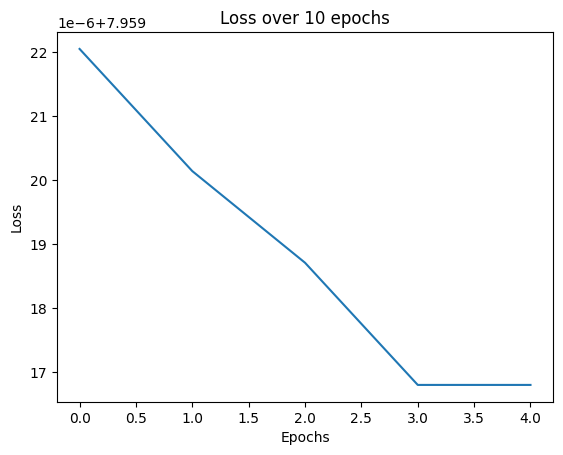

In [ ]:
plt.plot(loss)
plt.title("Loss over 10 epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

As we can see, the loss (mean squared error) gets minimized over 10 epochs through stochastic gradient descent. The RMSE of this implementation appears to be greater than the RMSE for matrix factorization with scipy's svds() function. Perhaps a lower RMSE could be obtained by using the implementations of matrix factorization with stochastic gradient descent by libraries such as Surprise.

### Testing

Now, we test the model for the same user id 9.

In [ ]:
user_history = getUserRatings(9, ratings, books)
printReccPT(user_history)

+------------------------------------------------------------------------------------------------------------------------------+-------------+
| Book Title                                                                                                                   | User Rating |
+------------------------------------------------------------------------------------------------------------------------------+-------------+
| The Great Gatsby                                                                                                             | 5           |
| Bel Canto                                                                                                                    | 5           |
| Breaking Dawn (Twilight, #4)                                                                                                 | 5           |
| Blubber                                                                                                                      | 5           |

In [ ]:
reccs = MFSGDRecommender(preds, 9, books, ratings, 5)
printReccPT(reccs, predicted=True)


+--------------------------------------+-----------------------------------+
| Book Title                           | Approximate Predicted User Rating |
+--------------------------------------+-----------------------------------+
| Cold Mountain                        | 4.359795570373535                 |
| The Fourth Protocol                  | 4.15678596496582                  |
| Ender's Shadow (Ender's Shadow, #1)  | 4.141913890838623                 |
| Beyond the Shadows (Night Angel, #3) | 4.114989280700684                 |
| Hunters of Dune (Dune Chronicles #7) | 4.100308418273926                 |
+--------------------------------------+-----------------------------------+


As it can be observed, both of the matrix factorization approaches yield different recommendations for a particular user. However, both sets of recommendations contain books that would be relevant to that particular user given their rating history.

The recommendations set obtained with svds() contains several fantasy and classic novels given that the user appears to like such novels and rates them highly. Whereas the recommendations set obtained with gradient descent contains several thriller and fantasy novels which are also in tune with the user's tastes. Thus, both of these approaches have picked up on latent patterns and factors that affect whether or not the user would like a particular book or not.

## Cold-start problem

Collaborative filtering approaches like the two implemented above with scipy's svds() and stochastic gradient descent suffer when a new user joins the ecosystem. This new user is completely unknown to the model with no history of any interactions with the items present in the dataset.

Some ways to deal with the cold-start problem and account for this new user include:

*   asking the user to rate K number of items. These interactions can then be used to predict the ratings the new user would potentially assign to other movies.
*   recommending items that are popular in the new users locale, city, country, or region. Recommendations can also be made based on what items are popular with people that are in the same demographics (age, gender, etc.) as the new user.

Even if data on interactions by the new user is obtained, it is difficult to incorporate this data and generate new recommendations based off these interactions with the above implemented collaborating filtering approaches. This is due to the fact that appending this interactions to the dataset and generating new recommendations will require us to retrain the model which can be a computationally expensive process.

### New user - Existing user similarity

One method to deal with accounting for a new user is to calculate the similarity of the new user with existing users in the database, select K most similar users and, based on the rating they have given to the items in the dataset, predict what the new user would rate the items in the dataset.

The similarity between users is calculated with cosine similarity.

<p><center><h3>

$cos(\theta) = \frac{A . B}{||A|| ||B||}$

</h3></center></p>


Once the cosine similarity between the given user and all the users in the dataset is calculated, top K most similar users are selected. With these selected users, the predicted rating $r_i$ by the new user for a book $i$ is calculated by the following equation:


<p><center>
<h3>$r_i = \frac{\sum (S_{nj} \times R_{ij})}{\sum S_{nj}}$</h3>
</center></p>


Where $S_{nj}$ is the similarity of the new user with an existing user $ j$ and $R_{ij}$ is the rating given by existing user $j$ to a book $i$.

In [ ]:
def getNewUserInput(K):

  '''

  For testing purposes.

  In order to avoid overloading the print output of this function, the user is shown just the first fifty books in the
  dataset. In a book recommendation app, this could be a drop-down/gallery type input where the user is shown all the
  titles in the dataset and is asked to rate K books. Perhaps a search bar as well to make the UI more intuitive.

  Because of the aforementioned reasons, no input handling is implemented.

  '''

  ip = pd.Series(index=books["book_id"], dtype="float64").fillna(0)
  ratings = []

  pt = PrettyTable()
  titles50 = books["title"].to_list()[:50]
  bids50 = books["book_id"].to_list()[:50]

  pt.add_column("Book id", bids50)
  pt.add_column("Book title", titles50)
  pt.align = 'l'
  print(pt)

  print("Rate {} books".format(K))

  br = []

  for i in range(K):
    bid = input("Enter book id to rate: ")
    bid = int(bid)

    rating = input("Enter rating (out of 5): ")
    rating = float(rating)

    br.append((bid, rating))

  for i, r in br:
    ip[i] = r

  np_input = ip.to_numpy()[np.newaxis, :]
  return np_input

In [ ]:
def NESimilarity(user_vec, matrix_df,num_sim):
  sims = np.zeros(shape=(ratings["user_id"].nunique(), 1))

  for i in range(len(matrix_df)):
    np_arr = matrix_df.iloc[i].to_numpy()
    sims[i,0] = np.dot(user_vec,np_arr)/(np.linalg.norm(user_vec)*np.linalg.norm(np_arr))
  sim_df = pd.DataFrame(sims, columns=["Similarity"], index=matrix_df.index)
  sim_df = sim_df.sort_values("Similarity", ascending=False)
  n_simusers = sim_df.head(num_sim)

  book_vec = np.zeros(shape=(1, 10000))

  for i in range(1, 10001):
    for j in n_simusers.index.values:
      book_vec[:,i-1] += n_simusers.loc[j].item() * matrix_df.loc[j][i]

  book_vec = book_vec/np.sum(n_simusers["Similarity"])
  book_vec_df = pd.DataFrame(book_vec, columns = matrix_df.columns)
  return book_vec_df


In [ ]:
def NUHistory(user_vec, books_df):
  user_ratings = pd.DataFrame(user_vec, columns=books_df["book_id"])
  non_zero_columns = user_ratings.columns[user_ratings.iloc[0] != 0]
  filtered_df = user_ratings[non_zero_columns]
  sorted_df_desc = filtered_df.sort_values(by=filtered_df.index[0], axis=1, ascending=False)
  sorted_df_desc = sorted_df_desc.iloc[0]

  book_ids = sorted_df_desc.index.values.tolist()
  book_ratings = sorted_df_desc.to_list()
  book_tr = []
  for i in range(len(book_ids)):
    book_tr.append((getBookTitle(book_ids[i], books_df), book_ratings[i]))
  return book_tr

In [ ]:
def NURecommender(user_vec, matrix_df, num_sim, books_df, K):
  u_rating_df = pd.DataFrame(user_vec, columns=books_df["book_id"])
  non_zero_columns = u_rating_df.columns[u_rating_df.iloc[0] != 0]
  filtered_df = u_rating_df[non_zero_columns]
  already_rated = filtered_df.columns.to_list()

  reccs_df = NESimilarity(user_vec, matrix_df, num_sim)
  not_rated = reccs_df.drop(columns=already_rated)

  pred_ratings_for_user = not_rated.sort_values(by=not_rated.index[0], axis=1, ascending=False).iloc[0][:K]
  recommended_book_list = pred_ratings_for_user.index.values.tolist()
  pred_ratings_for_user = pred_ratings_for_user.to_list()
  recommended_book_tr = []

  for i in range(len(recommended_book_list)):
    recommended_book_tr.append((getBookTitle(recommended_book_list[i], books_df), pred_ratings_for_user[i]))

  return recommended_book_tr



In [ ]:
inp = getNewUserInput(5)

+---------+------------------------------------------------------------------+
| Book id | Book title                                                       |
+---------+------------------------------------------------------------------+
| 1       | The Hunger Games (The Hunger Games, #1)                          |
| 2       | Harry Potter and the Sorcerer's Stone (Harry Potter, #1)         |
| 3       | Twilight (Twilight, #1)                                          |
| 4       | To Kill a Mockingbird                                            |
| 5       | The Great Gatsby                                                 |
| 6       | The Fault in Our Stars                                           |
| 7       | The Hobbit                                                       |
| 8       | The Catcher in the Rye                                           |
| 9       | Angels & Demons  (Robert Langdon, #1)                            |
| 10      | Pride and Prejudice                     

In [ ]:
nuh = NUHistory(inp, books)
printReccPT(nuh)

+-----------------------------------------+-------------+
| Book Title                              | User Rating |
+-----------------------------------------+-------------+
| The Time Traveler's Wife                | 5.0         |
| Little Women (Little Women, #1)         | 5.0         |
| Fahrenheit 451                          | 5.0         |
| Gone Girl                               | 4.0         |
| Fifty Shades of Grey (Fifty Shades, #1) | 4.0         |
+-----------------------------------------+-------------+


In [ ]:
reccs = NURecommender(inp, matrix_df, 10, books, 5)    # Recommend 5 books based on similarity with 10 most similar users in the dataset
printReccPT(reccs, predicted=True)

+-----------------------------------------+-----------------------------------+
| Book Title                              | Approximate Predicted User Rating |
+-----------------------------------------+-----------------------------------+
| To Kill a Mockingbird                   | 4.29889548374304                  |
| Pride and Prejudice                     | 3.2127155655937014                |
| The Hunger Games (The Hunger Games, #1) | 3.082169045071247                 |
| Jane Eyre                               | 2.9158357237406083                |
| Romeo and Juliet                        | 2.9145282612755135                |
+-----------------------------------------+-----------------------------------+


It can be noticed that the recommended books for the new user are similar to the books that they have already rated. The most of the rated books feature female main characters which is also the case with the recommended set of books. This shows that even with trying to serve recommendations to a new user based on similarity between their tastes and the tastes of the existing users, some of the latent features in the new user's rating history are picked up and can be seen in the set of recommendations.

Thus, this represents a somewhat effective way of dealing with the cold-start problem without having to retrain the entire model which, with extremely large datasets, may not be feasible especially when serving timely recommendations to the users is a must.